In [1]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np

import json
import argparse
import copy

import h5py

from matplotlib.colors import LogNorm
from scipy.ndimage import gaussian_filter
from scipy.interpolate import interp1d


from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=67.74, Om0=0.3089)
hlittle = cosmo.H0.value / 100

from astropy import units as u

from lightcone_utils import load_data, show_map, plot_mean, arcsec_to_cMpc, dz_to_dcMpc

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

base_dir = "../dataset/generated_data_lightcone"
output_dir = "{}/figures".format(base_dir)
os.makedirs(output_dir, exist_ok=True)

from line_model import line_dict 
line_names = list(line_dict.keys())
NLINE = len(line_names)

def my_savefig(fsave):
    if fsave is not None:
        plt.tight_layout()
        plt.savefig(fsave, dpi=300, bbox_inches="tight")
        print("Saved figure to", fsave)

In [2]:
path = "{}/pinocchio.run1.7200sec_zmin0.2_zmax6.0_dz0.005.h5".format(base_dir)
path = "{}/pinocchio.run1.7200sec_zmin0.2_zmax6.0_dz0.0010.h5".format(base_dir)
with h5py.File(path, "r") as f:
    attrs = dict(f.attrs)
    data = f["/SFR"][:]

side_length = attrs["side_length"]
zmin = attrs["redshift_min"]
zmax = attrs["redshift_max"]
use_logz = attrs["use_logz"]
dz = attrs["dz"]

if use_logz:
    log_redshifts = np.arange(np.log10(zmin+1), np.log10(zmax+1), dz)
    redshifts = 10**log_redshifts - 1
    dredshifts = redshifts[1:] - redshifts[:-1]
    redshifts = redshifts[:data.shape[-1]]

else:
    redshifts = np.arange(zmin, zmax, dz)

print(data.shape)
print(redshifts.shape)
print("Use logz: ", use_logz)

(720, 720, 765)
(765,)
Use logz:  True


/tmp/ipykernel_1042864/684066008.py:4: RuntimeWarning: divide by zero encountered in log10
  image = np.log10( image )


Saved figure to ../dataset/generated_data_lightcone/figures/sfr_lightcone.png


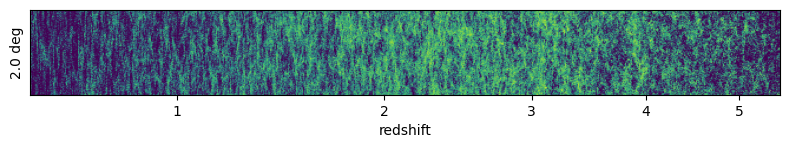

In [3]:
plt.figure(figsize=(8, 2))
image = data[:,:180,:].sum(axis=1)
#image = gaussian_filter(image, sigma=[0.1,0.2])
image = np.log10( image )

vmax= np.nanmax(image) * 0.8

cmap = plt.cm.viridis
cmap.set_bad(color=cmap(0))
plt.imshow(image, origin="lower", aspect="auto", cmap=cmap, vmax=vmax) #, vmin=vmin, vmax=vmax)

plt.yticks([])
plt.ylabel("{:.1f} deg".format(side_length / 3600))

tick_values = [1,2,3,4,5]
interpolator = interp1d(redshifts, np.arange(len(redshifts)), bounds_error=False, fill_value="extrapolate")
tick_positions = interpolator(tick_values)
plt.xticks(ticks=tick_positions, labels=tick_values)

tick_min = interpolator(0.5)
tick_max = interpolator(5.5)
plt.xlim([tick_min, tick_max])
plt.xlabel("redshift")

ax = plt.gca()

ax.set_aspect(0.28)
ax.set_aspect(0.1)

my_savefig("{}/sfr_lightcone.png".format(output_dir))

Saved figure to ../dataset/generated_data_lightcone/figures/z_sfrd.pdf


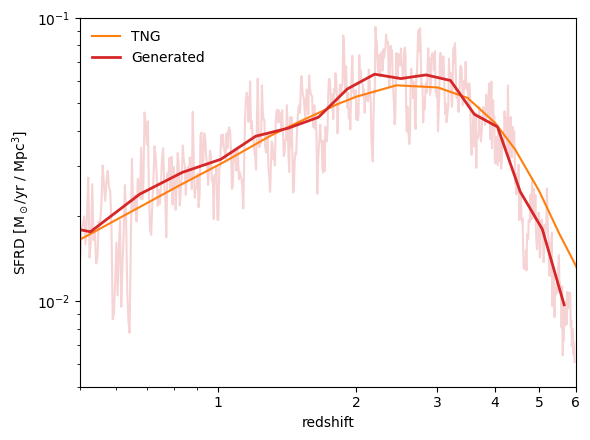

In [4]:
tng_data = np.loadtxt("./sfrd_TNG300-1_selected.txt")
z_tng = tng_data[:, 0]
sfrd_tng = tng_data[:, 1]

if use_logz:
    side_length_mpc = np.array([ arcsec_to_cMpc(side_length, z, cosmo=cosmo, l_with_hlittle=False) for z in redshifts ])
    dl_mpc = np.array([ dz_to_dcMpc(_dz, z, cosmo=cosmo, l_with_hlittle=False) for _dz, z in zip(dredshifts, redshifts) ])
else:
    side_length_mpc = np.array([ arcsec_to_cMpc(side_length, z, cosmo=cosmo, l_with_hlittle=False) for z in redshifts ])
    dl_mpc = np.array([ dz_to_dcMpc(dz, z, cosmo=cosmo, l_with_hlittle=False) for z in redshifts ])

sfr_total = data.sum(axis=(0, 1)) 
volume = side_length_mpc**2 * dl_mpc


sfrd_original = sfr_total / volume

n = 40
nz = len(redshifts)

istart = nz - nz//n * n

sfr_total = sfr_total[istart:]  # Ensure length is a multiple of n
sfr_total = sfr_total.reshape(-1, n).sum(axis=1)

volume = volume[istart:]  # Ensure length is a multiple of n
volume = volume.reshape(-1, n).sum(axis=1)

sfrd = sfr_total / volume

redshifts_now = redshifts[istart:]  # Ensure length is a multiple of n
redshifts_now = redshifts_now.reshape(-1, n).mean(axis=1)

"""
def moving_average(arr, n):
    kernel = np.ones(n) / n
    return np.convolve(arr, kernel, mode='same')

sfrd = moving_average(sfrd, 200)
"""


plt.figure(figsize=(6,4.5))
if use_logz:
    plt.plot(redshifts, sfrd_original, color=colors[3], alpha=0.2)

    plt.plot(z_tng, sfrd_tng, label="TNG", color=colors[1])

    plt.plot(redshifts_now, sfrd, label="Generated", color=colors[3], lw=2)
    plt.xscale("log")
    plt.xticks(ticks=[1, 2, 3, 4, 5, 6], labels=[1, 2, 3, 4, 5, 6])

else:
    plt.plot(z_tng, sfrd_tng, label="TNG", color=colors[1])
    plt.plot(redshifts_now, sfrd, label="Generated", color=colors[3])
    
plt.xlim([0.5, 6])
plt.xlabel("redshift")

plt.yscale("log")
plt.ylim([5e-3, 1e-1])
plt.ylabel(r"$\rm SFRD \ [M_\odot / yr \ /\  Mpc^3 ]$")

plt.legend(frameon=False)
#plt.grid()
my_savefig("{}/z_sfrd.pdf".format(output_dir))

## Mock intensity map

# Load ../dataset/generated_data_lightcone/pinocchio.run1.7200sec_fmin248_fmax301_R500.h5
Total intensity CO(3-2): 7.763359e+08
Total intensity CO(4-3): 5.531678e+08
Total intensity CO(5-4): 5.042005e+08
Total intensity CO(6-5): 3.485994e+08
Total intensity CO(7-6): 2.676527e+08
Total intensity CO(8-7): 2.493756e+08
Total intensity CO(9-8): 1.669451e+08
Total intensity CO(10-9): 1.107852e+08
Total intensity CO(11-10): 6.918710e+07
Total intensity CO(12-11): 3.225719e+07
Total intensity CO(13-12): 1.416494e+06
Total intensity [CII]158: 1.969774e+08
Total intensity [CI](1-0): 3.823172e+08
Total intensity [CI](2-1): 2.334796e+08
freqency shape:  (96,)
intensity shape:  (240, 240, 95)
Projection along y-axis: 240 slices


lightcone_utils.py:454: RuntimeWarning: divide by zero encountered in log10
lightcone_utils.py:454: RuntimeWarning: divide by zero encountered in log10
lightcone_utils.py:454: RuntimeWarning: divide by zero encountered in log10
lightcone_utils.py:454: RuntimeWarning: divide by zero encountered in log10
lightcone_utils.py:454: RuntimeWarning: divide by zero encountered in log10
lightcone_utils.py:454: RuntimeWarning: divide by zero encountered in log10
lightcone_utils.py:454: RuntimeWarning: divide by zero encountered in log10


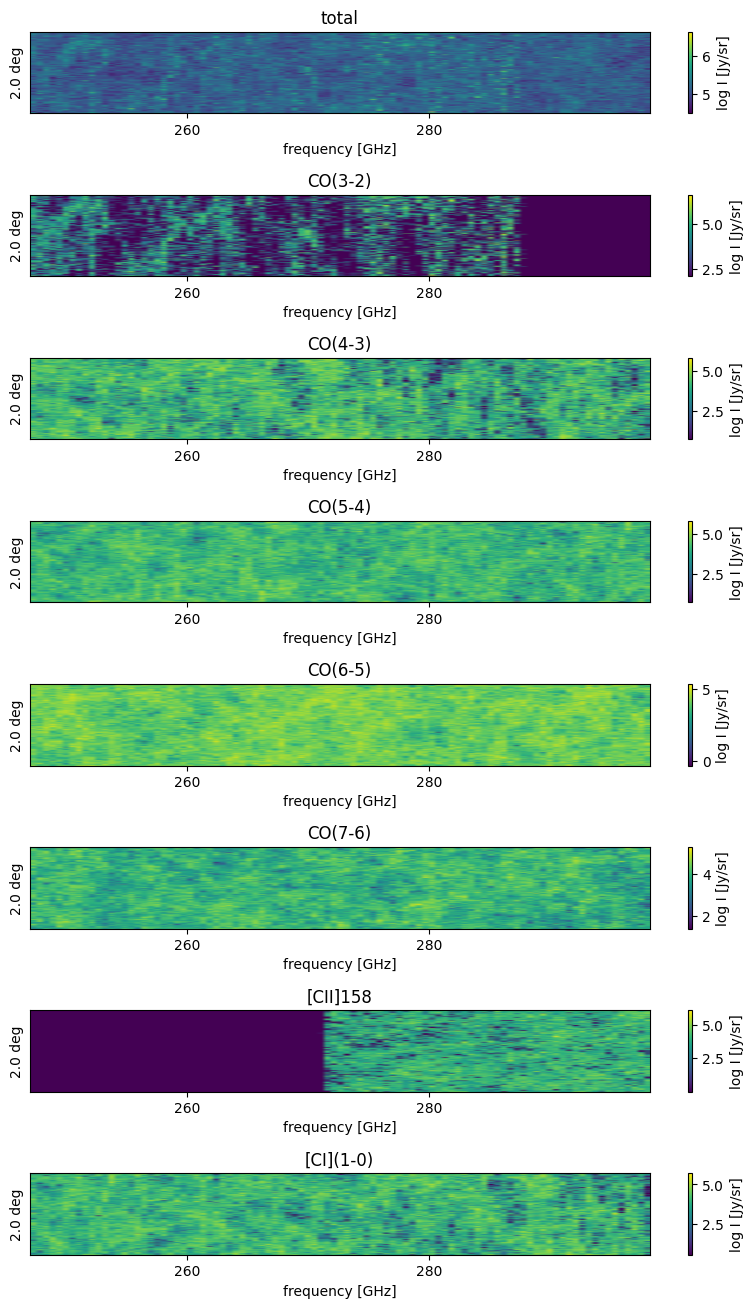

In [3]:
fname = "{}/pinocchio.run1.7200sec_fmin248_fmax301_R500.h5".format(base_dir)
freq, intensity, intensity_line, attrs = load_data(fname)
side_length = attrs['side_length']
lines_to_show = ["CO(2-1)", "CO(3-2)", "CO(4-3)", "CO(5-4)", "CO(6-5)", "CO(7-6)", "[CII]158", "[CI](1-0)"]
show_map(freq, intensity, intensity_line, side_length, dy=-1, lines_to_show=lines_to_show, log_scale=True)